# Neural Architecture Search (NAS) Strategies

This notebook demonstrates different Neural Architecture Search (NAS) strategies for finding optimal neural network architectures. We'll implement and compare the following approaches:

1. **Random Search** - Efficient sampling with NumPy
2. **Reinforcement Learning** - Policy Gradient and Q-learning approaches
3. **Evolutionary Search** - Simple Genetic Algorithm and NSGA-II
4. **Gradient-Based Search** - DARTS (Differentiable Architecture Search) with first and second-order approximations

Each strategy will be evaluated on accuracy and inference time to provide a comprehensive comparison.

### CIFAR-10 Dataset
The dataset is the CIFAR-10 data, which is widely used to train machine learning and computer vision algorithms and research. It is a multi-class dataset. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. 

## 1. Setup and Imports

First, let's import the necessary libraries and set up our environment.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from tqdm.notebook import tqdm

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Import our custom modules
from src.library.nas.search_space import SearchSpace
from src.library.nas.utils import get_dataset, train_model, evaluate_model, get_best_torch_device, plot_comparison_results, plot_pareto_front
from src.library.nas.random_search import RandomSearch
from src.library.nas.reinforcement_learning_search import ReinforcementLearningSearch
from src.library.nas.evolutionary_search import EvolutionarySearch
from src.library.nas.darts_search import DARTSSearch

## 2. Search Space Definition

The search space defines the possible neural network architectures that our NAS strategies will explore. Our search space includes:

- Different convolutional operations (3x3, 5x5, 7x7 convolutions, max/avg pooling)
- Various channel sizes
- Different activation functions
- Pooling operations
- Fully connected layer sizes and dropout rates
- Variable number of layers

Let's examine our search space:

In [2]:
# Initialize the search space
search_space = SearchSpace()

# Print search space details
print("Search Space Details:")
print(f"Convolutional Operations: {[op[0] for op in search_space.conv_ops]}")
print(f"Channel Choices: {search_space.channel_choices}")
print(f"Number of Layers Range: {search_space.num_layers_range}")
print(f"Activation Functions: {[act[0] for act in search_space.activation_ops]}")
print(f"Pooling Operations: {[pool[0] for pool in search_space.pooling_ops]}")
print(f"FC Layer Sizes: {search_space.fc_sizes}")
print(f"Dropout Rates: {search_space.dropout_rates}")

Search Space Details:
Convolutional Operations: ['conv3x3', 'conv5x5', 'conv7x7', 'max_pool3x3', 'avg_pool3x3']
Channel Choices: [16, 32, 64, 128]
Number of Layers Range: (2, 6)
Activation Functions: ['relu', 'leaky_relu', 'elu', 'selu']
Pooling Operations: ['max_pool2x2', 'avg_pool2x2']
FC Layer Sizes: [128, 256, 512, 1024]
Dropout Rates: [0.0, 0.2, 0.3, 0.5]


Let's sample a random architecture from our search space to understand its structure:

In [3]:
# Sample a random architecture
random_architecture = search_space.sample_random_architecture()

# Print architecture details
print("Random Architecture Sample:")
print("\nConvolutional Layers:")
for i, layer in enumerate(random_architecture['conv_layers']):
    print(f"Layer {i+1}:")
    print(f"  Operation: {layer['op']}")
    print(f"  Channels: {layer['in_channels']} -> {layer['out_channels']}")
    print(f"  Activation: {layer['activation']}")
    print(f"  Pooling: {layer['pooling'] if layer['use_pooling'] else 'None'}")

print("\nFully Connected Layers:")
for i, layer in enumerate(random_architecture['fc_layers']):
    print(f"Layer {i+1}:")
    print(f"  Size: {layer['in_features']} -> {layer['out_features']}")
    print(f"  Activation: {layer['activation'] if layer['activation'] else 'None'}")
    print(f"  Dropout: {layer['dropout_rate']}")

Random Architecture Sample:

Convolutional Layers:
Layer 1:
  Operation: avg_pool3x3
  Channels: 3 -> 64
  Activation: elu
  Pooling: None
Layer 2:
  Operation: avg_pool3x3
  Channels: 64 -> 16
  Activation: elu
  Pooling: avg_pool2x2
Layer 3:
  Operation: conv7x7
  Channels: 16 -> 64
  Activation: elu
  Pooling: None
Layer 4:
  Operation: conv7x7
  Channels: 64 -> 128
  Activation: relu
  Pooling: avg_pool2x2
Layer 5:
  Operation: conv7x7
  Channels: 128 -> 32
  Activation: relu
  Pooling: None

Fully Connected Layers:
Layer 1:
  Size: 2048 -> 1024
  Activation: leaky_relu
  Dropout: 0.5
Layer 2:
  Size: 1024 -> 10
  Activation: None
  Dropout: 0.0


Let's build a model from this architecture and check its structure:

In [4]:
# Build a model from the random architecture
random_model = search_space.build_model_from_architecture(random_architecture)

# Print model summary
print(random_model)

Sequential(
  (conv_0): Sequential(
    (0): AvgPool2d(kernel_size=3, stride=1, padding=1)
    (1): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (act_0): ELU(alpha=1.0)
  (conv_1): Sequential(
    (0): AvgPool2d(kernel_size=3, stride=1, padding=1)
    (1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (act_1): ELU(alpha=1.0)
  (pool_1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_2): Conv2d(16, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (act_2): ELU(alpha=1.0)
  (conv_3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (act_3): ReLU()
  (pool_3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_4): Conv2d(128, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (act_4): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_0): Linear(in_features=2048, out_features=1024, bias=True)
  (fc_act_0): LeakyReLU(negative_slope=0.1)
  (dropout_0): Dropout(p

## 3. Evaluation Framework

Before diving into the NAS strategies, let's set up our evaluation framework. We'll use the CIFAR-10 dataset and evaluate models based on accuracy and inference time.

In [5]:
# Get the best available device (GPU, MPS, or CPU)
device = get_best_torch_device()
print(f"Using device: {device}")

# Load datasets with a small subset for faster evaluation during NAS
train_loader, val_loader, test_loader = get_dataset(batch_size=64, small_subset=True)

# Print dataset information
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Using device: mps
Training batches: 15
Validation batches: 2
Test batches: 4


Let's test our evaluation framework by training and evaluating the random model:

In [6]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(random_model.parameters(), lr=0.001)

# Train the model for a few epochs
history = train_model(
    model=random_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=2,  # test
    verbose=True
)

Epoch [1/2], Train Loss: 2.1527, Val Loss: 2.1068, Val Acc: 22.00%
Epoch [2/2], Train Loss: 2.0214, Val Loss: 2.0282, Val Acc: 28.00%


In [7]:
# Evaluate the model
eval_results = evaluate_model(
    model=random_model,
    test_loader=test_loader,
    device=device,
    verbose=True
)

Test Accuracy: 25.50%
Total inference time: 14.6442 seconds
Images per second: 13.66
Milliseconds per image: 73.22


## 4. Random Search Strategy

Random search is one of the simplest NAS strategies, but equally effective. It involves randomly sampling architectures from the search space and evaluating them.

### 4.1 Theory

Random search works by:
1. Sampling random architectures from the search space
2. Training and evaluating each architecture
3. Selecting the best performing architecture

Despite its simplicity, random search has several advantages:
- Simple to implement and parallelize
- No assumptions about the search space
- Can find good architectures with enough samples
- Provides a strong baseline for comparing other methods

### 4.2 Implementation

In [8]:
# Initialize random search
random_search = RandomSearch(
    search_space=search_space,
    num_samples=3,  # Number of random architectures to sample
    epochs_per_model=5,  # Number of epochs to train each model
    batch_size=32,
    device=device,
    small_subset=True  # Use a small subset of data for faster evaluation
)

In [9]:
# Perform random search
best_random_architecture, best_random_model = random_search.search(verbose=True)

Starting Random Search with 3 samples...


 33%|███▎      | 1/3 [02:46<05:32, 166.34s/it]

New best architecture found! Accuracy: 36.50%


100%|██████████| 3/3 [08:25<00:00, 168.39s/it]

New best architecture found! Accuracy: 39.50%
Random Search completed in 8.42 minutes
Best architecture accuracy: 39.50%


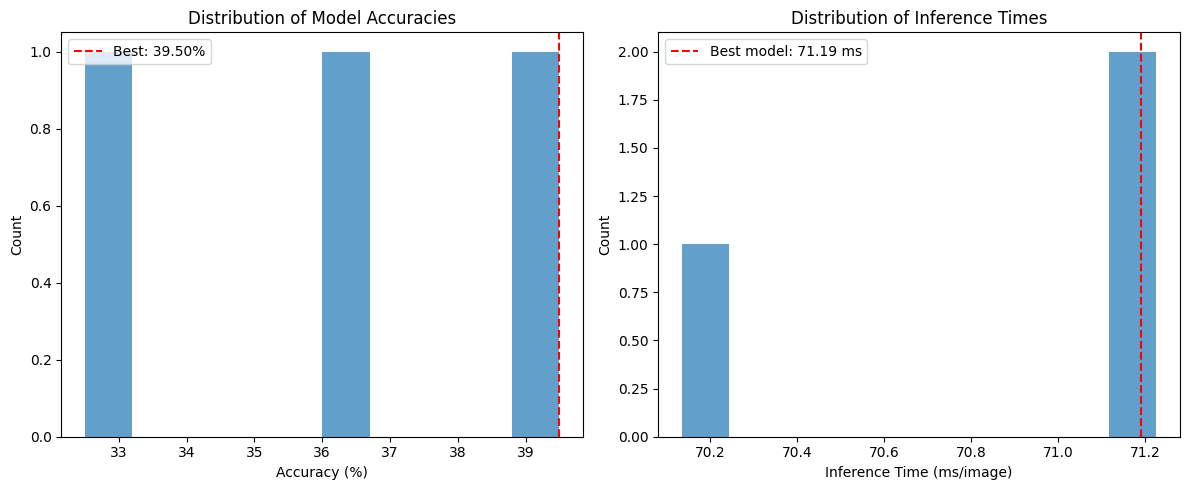

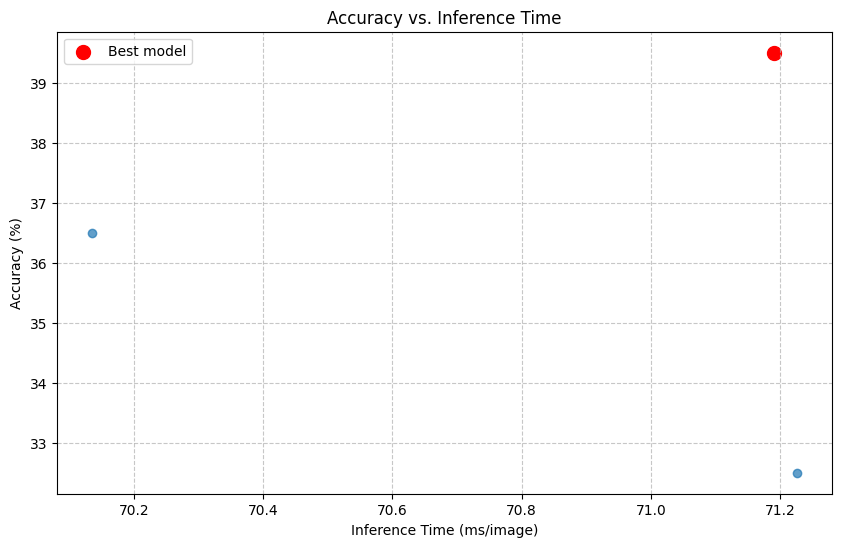

In [10]:
# Plot search results
random_search.plot_search_results()

In [11]:
# Get a summary of the best architecture found
print(random_search.get_best_architecture_summary())

Best Architecture Summary:
Accuracy: 39.50%

Convolutional Layers:
Layer 1:
  Operation: avg_pool3x3
  Channels: 3 -> 32
  Activation: selu
  Pooling: None
Layer 2:
  Operation: max_pool3x3
  Channels: 32 -> 64
  Activation: selu
  Pooling: max_pool2x2
Layer 3:
  Operation: max_pool3x3
  Channels: 64 -> 16
  Activation: selu
  Pooling: None

Fully Connected Layers:
Layer 1:
  Size: 4096 -> 10
  Activation: None
  Dropout: 0.2



## 5. Reinforcement Learning Strategies

Reinforcement Learning (RL) is a powerful approach for NAS, where an agent learns to design neural architectures through trial and error.

### 5.1 Theory

In RL-based NAS:
- A controller (agent) generates neural architectures
- The performance of each architecture (e.g., validation accuracy) serves as the reward
- The controller learns to maximize the expected reward by generating better architectures

We'll implement two RL approaches:
1. **Policy Gradient (REINFORCE)**: Directly learns a policy to generate architectures
2. **Q-Learning**: Learns the value of architecture decisions

### 5.2 Policy Gradient Implementation

In [6]:
# Initialize policy gradient search
policy_gradient_search = ReinforcementLearningSearch(
    search_space=search_space,
    method='policy_gradient',
    num_episodes=10,  # Number of episodes/iterations
    epochs_per_model=5,  # Number of epochs to train each model
    batch_size=64,
    device=device,
    small_subset=True  # Use a small subset of data for faster evaluation
)

In [7]:
# Perform policy gradient search
best_pg_architecture, best_pg_model = policy_gradient_search.search(verbose=True)

Starting Policy Gradient Search with 10 episodes...


 50%|█████     | 5/10 [15:37<16:48, 201.68s/it]

Episode 5/10, Best accuracy: 38.00%


100%|██████████| 10/10 [29:59<00:00, 179.90s/it]

Episode 10/10, Best accuracy: 41.00%
Policy Gradient Search completed in 29.98 minutes
Best architecture accuracy: 41.00%


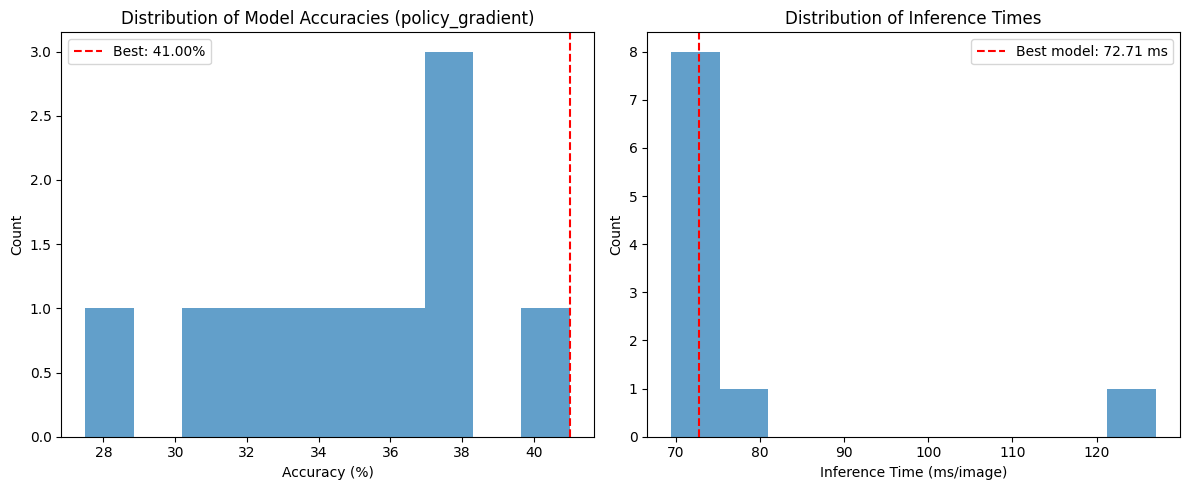

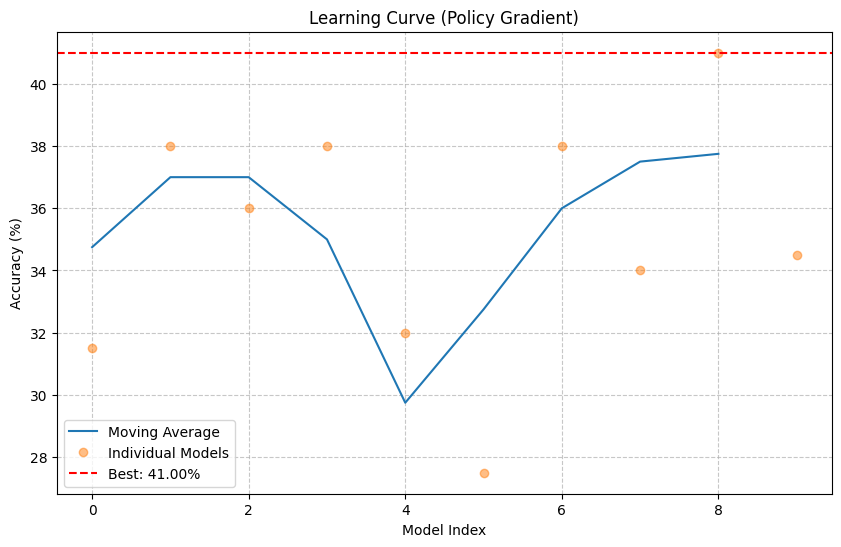

In [8]:
# Plot search results
policy_gradient_search.plot_search_results()

In [9]:
# Get a summary of the best architecture found
print(policy_gradient_search.get_best_architecture_summary())

Best Architecture Summary (policy_gradient):
Accuracy: 41.00%

Convolutional Layers:
Layer 1:
  Operation: conv5x5
  Channels: 3 -> 32
  Activation: relu
  Pooling: None
Layer 2:
  Operation: max_pool3x3
  Channels: 32 -> 128
  Activation: elu
  Pooling: None

Fully Connected Layers:
Layer 1:
  Size: 131072 -> 10
  Activation: None
  Dropout: 0.3



### 5.3 Q-Learning Implementation

In [10]:
# Initialize Q-learning search
q_learning_search = ReinforcementLearningSearch(
    search_space=search_space,
    method='q_learning',
    num_episodes=10,  # Number of episodes/iterations
    epochs_per_model=5,  # Number of epochs to train each model
    batch_size=64,
    device=device,
    small_subset=True  # Use a small subset of data for faster evaluation
)

In [11]:
# Perform Q-learning search
best_ql_architecture, best_ql_model = q_learning_search.search(verbose=True)

Starting Q-Learning Search with 10 episodes...


 50%|█████     | 5/10 [14:27<14:25, 173.09s/it]

Episode 5/10, Epsilon: 0.9752, Best accuracy: 38.00%


100%|██████████| 10/10 [28:46<00:00, 172.68s/it]

Episode 10/10, Epsilon: 0.9511, Best accuracy: 38.00%
Q-Learning Search completed in 28.78 minutes
Best architecture accuracy: 38.00%


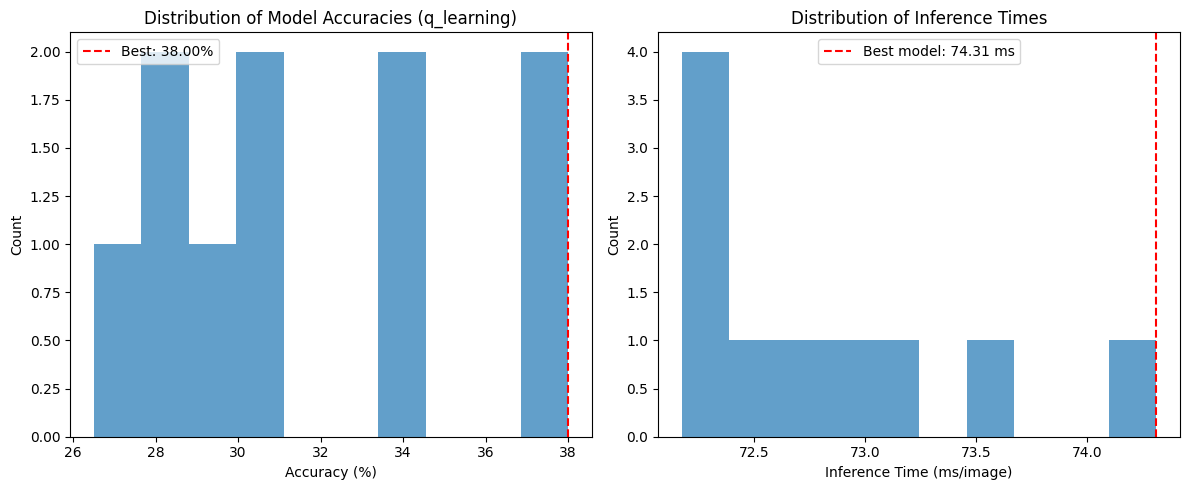

In [12]:
# Plot search results
q_learning_search.plot_search_results()

In [13]:
# Get a summary of the best architecture found
print(q_learning_search.get_best_architecture_summary())

Best Architecture Summary (q_learning):
Accuracy: 38.00%

Convolutional Layers:
Layer 1:
  Operation: conv3x3
  Channels: 3 -> 64
  Activation: elu
  Pooling: None
Layer 2:
  Operation: conv5x5
  Channels: 64 -> 32
  Activation: selu
  Pooling: max_pool2x2
Layer 3:
  Operation: conv7x7
  Channels: 32 -> 64
  Activation: selu
  Pooling: None
Layer 4:
  Operation: conv3x3
  Channels: 64 -> 128
  Activation: relu
  Pooling: avg_pool2x2

Fully Connected Layers:
Layer 1:
  Size: 8192 -> 256
  Activation: elu
  Dropout: 0.0
Layer 2:
  Size: 256 -> 10
  Activation: None
  Dropout: 0.0



## 6. Evolutionary Search Strategies

Evolutionary algorithms mimic natural selection to evolve neural architectures over generations.

### 6.1 Theory

Evolutionary NAS works by:
1. Maintaining a population of architectures
2. Selecting the fittest architectures as parents
3. Creating new architectures through crossover and mutation
4. Replacing the population with the new generation

We'll implement two evolutionary approaches:
1. **Simple Genetic Algorithm**: Optimizes for a single objective (accuracy)
2. **NSGA-II**: Multi-objective optimization considering both accuracy and inference time

### 6.2 Simple Genetic Algorithm Implementation

In [6]:
# Initialize simple genetic algorithm search
simple_ga_search = EvolutionarySearch(
    search_space=search_space,
    method='simple_ga',
    population_size=10,  # Size of the population
    num_generations=5,  # Number of generations
    mutation_rate=0.2,  # Probability of mutation
    crossover_rate=0.5,  # Probability of crossover
    tournament_size=3,  # Size of tournament for selection
    epochs_per_model=5,  # Number of epochs to train each model
    batch_size=64,
    device=device,
    small_subset=True  # Use a small subset of data for faster evaluation
)

In [7]:
# Perform simple genetic algorithm search
best_ga_architecture, best_ga_model = simple_ga_search.search(verbose=True)

Starting SIMPLE GA Search with 10 individuals and 5 generations...
Evaluating 10 individuals...


 10%|█         | 1/10 [02:47<25:11, 167.95s/it]

New best architecture found! Accuracy: 33.50%


 20%|██        | 2/10 [05:40<22:44, 170.59s/it]

New best architecture found! Accuracy: 34.00%


 30%|███       | 3/10 [08:27<19:43, 169.11s/it]

New best architecture found! Accuracy: 40.50%


100%|██████████| 10/10 [28:11<00:00, 169.13s/it]


Generation 0: Avg Fitness = 35.60%, Best Fitness = 40.50%

Generation 1/5
Evaluating 10 individuals...


 60%|██████    | 6/10 [13:52<10:13, 153.36s/it]

New best architecture found! Accuracy: 44.00%


100%|██████████| 10/10 [7:32:02<00:00, 2712.24s/it]


Generation 1: Avg Fitness = 36.10%, Best Fitness = 44.00%

Generation 2/5
Evaluating 10 individuals...


 40%|████      | 4/10 [08:26<13:46, 137.76s/it]

New best architecture found! Accuracy: 44.50%


100%|██████████| 10/10 [25:26<00:00, 152.68s/it]


Generation 2: Avg Fitness = 40.00%, Best Fitness = 44.50%

Generation 3/5
Evaluating 10 individuals...


 80%|████████  | 8/10 [19:49<05:27, 163.85s/it]

New best architecture found! Accuracy: 46.50%


100%|██████████| 10/10 [25:34<00:00, 153.46s/it]


Generation 3: Avg Fitness = 40.95%, Best Fitness = 46.50%

Generation 4/5
Evaluating 10 individuals...


 10%|█         | 1/10 [00:11<01:41, 11.25s/it]


RuntimeError: Given groups=1, weight of size [64, 128, 7, 7], expected input[64, 64, 32, 32] to have 128 channels, but got 64 channels instead

In [ ]:
# Plot fitness history
simple_ga_search.plot_fitness_history()

In [ ]:
# Get a summary of the best architecture found
print(simple_ga_search.get_best_architecture_summary())

## 7. Gradient-Based Search (DARTS)

Differentiable Architecture Search (DARTS) is a gradient-based approach that relaxes the discrete architecture search space to a continuous one, allowing optimization via gradient descent.

### 7.1 Theory

DARTS works by:
1. Relaxing the discrete architecture choices to continuous weights
2. Training both the network weights and architecture weights simultaneously
3. Deriving the final discrete architecture from the learned continuous weights

We'll implement two DARTS variants:
1. **First-order approximation**: Simpler and faster, but less accurate
2. **Second-order approximation**: More accurate but computationally expensive

### 7.2 First-Order DARTS Implementation

In [17]:
# Initialize first-order DARTS search
first_order_darts_search = DARTSSearch(
    search_space=search_space,
    method='first_order',
    channels=16,  # Initial number of channels
    num_cells=8,  # Number of cells in the network
    epochs=10,  # Number of epochs for search
    batch_size=64,
    device=device,
    small_subset=True  # Use a small subset of data for faster evaluation
)

In [18]:
# Perform first-order DARTS search
best_fo_darts_architecture, best_fo_darts_model = first_order_darts_search.search(verbose=True)

Starting DARTS Search (first_order) for 10 epochs...

Epoch 1/10


  0%|          | 0/15 [00:23<?, ?it/s]


RuntimeError: Given groups=1, weight of size [32, 32, 3, 3], expected input[64, 16, 32, 32] to have 32 channels, but got 16 channels instead

In [ ]:
# Plot search history
first_order_darts_search.plot_search_history()

In [ ]:
# Plot architecture weights evolution
first_order_darts_search.plot_architecture_weights()

In [ ]:
# Get a summary of the best architecture found
print(first_order_darts_search.get_best_architecture_summary())

### 7.3 Second-Order DARTS Implementation

In [ ]:
# Initialize second-order DARTS search
second_order_darts_search = DARTSSearch(
    search_space=search_space,
    method='second_order',
    channels=16,  # Initial number of channels
    num_cells=8,  # Number of cells in the network
    epochs=10,  # Number of epochs for search
    batch_size=64,
    device=device,
    small_subset=True  # Use a small subset of data for faster evaluation
)

In [ ]:
# Perform second-order DARTS search
best_so_darts_architecture, best_so_darts_model = second_order_darts_search.search(verbose=True)

In [ ]:
# Plot search history
second_order_darts_search.plot_search_history()

In [ ]:
# Plot architecture weights evolution
second_order_darts_search.plot_architecture_weights()

In [ ]:
# Get a summary of the best architecture found
print(second_order_darts_search.get_best_architecture_summary())

## 8. Comparative Analysis

Now let's compare the performance of all the NAS strategies we've implemented.

In [ ]:
# Load the full test dataset for final evaluation
_, _, full_test_loader = get_dataset(batch_size=64, small_subset=False)

# Collect all models
models = {
    'Random Search': best_random_model,
    'Policy Gradient': best_pg_model,
    'Q-Learning': best_ql_model,
    'Simple GA': best_ga_model,
    'NSGA-II': best_nsga_model,
    'DARTS (First-Order)': best_fo_darts_model,
    'DARTS (Second-Order)': best_so_darts_model
}

# Evaluate all models on the full test dataset
results = {}

for name, model in models.items():
    print(f"\nEvaluating {name}...")
    eval_results = evaluate_model(
        model=model,
        test_loader=full_test_loader,
        device=device,
        verbose=True
    )
    results[name] = eval_results

In [ ]:
# Plot comparison of accuracy
plot_comparison_results(results, metric='accuracy')

In [ ]:
# Plot comparison of inference time
plot_comparison_results(results, metric='ms_per_image')

In [ ]:
# Plot Pareto front of accuracy vs. inference time
plot_pareto_front(results, x_metric='ms_per_image', y_metric='accuracy')

## 9. Conclusion

In this notebook, we've implemented and compared different Neural Architecture Search (NAS) strategies:

1. **Random Search**: Simple but effective baseline
2. **Reinforcement Learning**: Policy Gradient and Q-learning approaches
3. **Evolutionary Search**: Simple Genetic Algorithm
4. **Gradient-Based Search**: DARTS with first and second-order approximations


### Best Practices:

- **Random Search**: Great baseline and surprisingly effective for small search spaces
- **Reinforcement Learning**: Works well when the reward signal is clear and consistent
- **Evolutionary Search**: Excellent for multi-objective optimization (accuracy vs. efficiency)
- **DARTS**: Efficient for large search spaces but requires careful implementation

### Future Directions:

- Explore more advanced NAS methods like Once-for-All Networks or Neural Architecture Transfer
- Incorporate hardware-aware constraints for edge deployment
- Combine different search strategies for better results
- Apply NAS to different domains beyond image classification